# Code du projet d'apprentissage de Maxime Calio et Jules Crafa

## Librairies et fonctions 

### Import des librairies

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
import pandas as pd
import numpy as np


### Fonctions customisées

#### CNN

In [26]:
def create_cnn(x_train, y_train, nb_layers=1, drop=0):
    # permet de conserver la forme des données au fil de leur passage dans le cnn
    padding = 'same'
    
    # valeur du décalage appliqué à chaque filtre
    stride = 1
    
    # taille du noyau de convolution utilisé par les filtres
    kernel_size = 15
    
    # nombre de filtres utilisés
    filters = 5
    
    # fonction d'activation    
    activation = 'relu'
    
    # création de la couche d'entrée, dont la forme est celle d'1 série temporelle ESG
    input_layer = keras.layers.Input(x_train.shape[1:])
    
    # première couche de convolution, appliquant les paramétres
    conv_1 = keras.layers.Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        strides=stride,
        padding=padding,
        activation=activation
    )(input_layer)
    
    # couche de réduction du résultat de la convolution
    pooling_1 = keras.layers.MaxPooling1D(pool_size = 2, strides = 2, 
                                          padding='valid')(conv_1)
    
    # si on veut un modèle 2 couches, on réitère le processus
    if nb_layers == 2 :
    
        conv_2 = keras.layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            strides=stride,
            padding=padding,
            activation=activation
        )(pooling_1)
        pooling_2 = keras.layers.MaxPooling1D(pool_size = 2, strides = 2, 
                                            padding='valid')(conv_2)
    
        flattened = keras.layers.Flatten()(pooling_2)
        
    else:
        flattened = keras.layers.Flatten()(pooling_1)
        
    # flattened est une couche transformant la forme de la sortie, la renverse pour la rendre 
    # compatible    
        
    # couche de sortie, units = nb de classes, ici y_train.shape[1]
    output_layer = keras.layers.Dense(units=y_train.shape[1], activation='softmax')(flattened)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    # le modèle est renvoyé
    return model

#### RNN

In [27]:
def create_simple_rnn(x_train, y_train,units, drop=0, rec_drop=0):

    input_layer = keras.layers.Input(batch_shape=[1, x_train.shape[1], x_train.shape[2]])
    hidden_layer_1 = keras.layers.SimpleRNN(units=units, dropout=drop, recurrent_dropout=rec_drop, stateful=True, return_sequences=True)(input_layer)
    hidden_layer_2 = keras.layers.SimpleRNN(units=units, dropout=drop, recurrent_dropout=rec_drop, stateful=True)(hidden_layer_1)
    
    output_layer = keras.layers.Dense(units=y_train.shape[1])(hidden_layer_2)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [28]:
def create_complex_rnn(x_train, y_train,units, drop=0, rec_drop=0):
    input_layer = keras.layers.Input(batch_shape=[1, x_train.shape[1], x_train.shape[2]])
    lstm_1 = keras.layers.LSTM(units=units, dropout=drop, recurrent_dropout=rec_drop, stateful=True, return_sequences=True)(input_layer)
    lstm_2 = keras.layers.LSTM(units=units, dropout=drop, recurrent_dropout=rec_drop, stateful=True)(lstm_1)
    
    output_layer = keras.layers.Dense(activation='softmax',units=y_train.shape[1])(lstm_2)
    model=keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model


In [29]:
def train_rnn(model, x_train, y_train, nb_epoch):
    
    model.fit(x_train, y_train, batch_size=1, epochs=nb_epoch, verbose=1)

#### Modeler

In [30]:
def display_model(model):
    # affiche le résumé du modèle
    model.summary()
    # en créé une image
    return tf.keras.utils.plot_model(model, show_shapes=True)


In [31]:
def compile_model(model, mode='lstm', learning_r=0.01):
    """function to compile with preset parameters
    """
    
    if mode == 'lstm':
        optimizer_alg = tf.keras.optimizers.Adam(learning_rate=learning_r)
        model.compile(optimizer=optimizer_alg, loss='mean_squared_error', metrics=["accuracy"])

    if mode == 'cnn':
        optimizer_alg = tf.keras.optimizers.SGD(learning_rate=learning_r)
        model.compile(optimizer=optimizer_alg, loss='categorical_crossentropy', metrics=["accuracy"])

### Nettoyage des données

In [32]:
def create_x_y(df):
    # split the x's and y's
    x, y = df.iloc[:, 1:].values, df.iloc[:, 0].values
    
    # Make the labels an integer repartition
    encoder = preprocessing.LabelEncoder()
    y_transformed = encoder.fit_transform(y)
    
    # Make the labels a binary representation of their int
    encoder = preprocessing.OneHotEncoder()
    y_transformed = encoder.fit_transform(y_transformed.reshape(-1, 1))
    y_transformed = y_transformed.toarray()
    
    #Scale the X's
    max_abs_scaler = preprocessing.MaxAbsScaler()
    x_fitted = max_abs_scaler.fit_transform(x)    
    
    return x_fitted, y_transformed


In [33]:
def get_train_test_cnn(df_train, df_test):
    # on merge les dataframe en vue d'homogénéiser la normalisation des données
    lg_train = df_train.shape[0]

    df_test = df_test.reset_index(drop=True)
    train_test_df = pd.concat([df_train, df_test], axis=0)
    
    # on fit les x et y sur l'ensemble du dataframe
    x_fitted, y_fitted = create_x_y(train_test_df)
    
    # dans le cas du cnn 1d, il suffit de rajouter une dimension pour que le réseau comprenne la donnée
    x_fitted = x_fitted.reshape(x_fitted.shape[0],x_fitted.shape[1],1)
    
    x_train, y_train = x_fitted[:lg_train], y_fitted[:lg_train]
    x_test, y_test = x_fitted[lg_train:], y_fitted[lg_train:]
    
    return x_train, y_train, x_test, y_test


In [34]:
def get_train_test_rnn(df_train, df_test):
    
    # on merge les dataframe en vue d'homogénéiser la normalisation des données
    lg_train = df_train.shape[0]

    df_test = df_test.reset_index(drop=True)
    train_test_df = pd.concat([df_train, df_test], axis=0)
    
    # on fit les x et y sur l'ensemble du dataframe
    x_fitted, y_fitted = create_x_y(train_test_df)
    
    #reshape the inner arrays of x_fitted
    # chaque série temporelle est une suite de séquences de 1, les unes à la suite des autres
    x_as_list = x_fitted.tolist()
    x_to_fitted = [np.reshape(x, (-1, 1)) for x in x_as_list]
    
    x_fitted = np.array(x_to_fitted) 
    
    x_train, y_train = x_fitted[:lg_train], y_fitted[:lg_train]
    x_test, y_test = x_fitted[lg_train:], y_fitted[lg_train:]
    
    return x_train, y_train, x_test, y_test

## DATAS

### Import des données

In [35]:
train_df = pd.read_csv('https://maxime-devanne.com/datasets/ECG200/ECG200_TRAIN.tsv', sep='\t', header=None)
test_df = pd.read_csv('https://maxime-devanne.com/datasets/ECG200/ECG200_TEST.tsv', sep='\t', header=None)

### Traitement des données

#### Jeux de données CNN

In [36]:
x_train_cnn, y_train, x_test_cnn, y_test = get_train_test_cnn(
                                                        train_df,
                                                        test_df
                                                        )

### Jeux de données RNN

In [47]:
x_train_rnn, y_train, x_test_rnn, y_test = get_train_test_rnn(
                                                        train_df,
                                                        test_df
                                                        )

## CNN Models

### Fonction d'obtentions des rnn suivants une liste de paramètres

In [38]:
def get_cnn_models(nb_layers, params_cnn):
    res = []
    for param in params_cnn:
    
        local_res = param.copy()
        
        model = create_cnn(x_train_cnn, y_train, nb_layers=1, drop=param['drop'])
        compile_model(model, mode='cnn', learning_r=param['learning_rate'])
        
        for i in range(3):
            epochs = 50 + i *50
            model.fit(x_train_cnn, y_train, batch_size=25, epochs=50, verbose=0)
        
            loss,acc = model.evaluate(x_test_cnn, y_test, batch_size=25, verbose=False)
            
            local_res[str(epochs)] = {'loss': loss, 'acc':acc}
        
        res.append(local_res)
    
    return res

### Paramètrages des réseaux cnn

In [39]:
params_cnn = []
for i in range(1, 7):
    for j in range(2, 9, 2):
        params_cnn.append(
            {
                'drop': i/10,
                'learning_rate': j/10
            }
        )
        

### Résultats

#### Modèles 1 couche (long)

In [40]:
layer_1_res = get_cnn_models(1, params_cnn)
print(layer_1_res)

[{'drop': 0.1, 'learning_rate': 0.2, '50': {'loss': 0.42606398463249207, 'acc': 0.8199999928474426}, '100': {'loss': 0.4502497911453247, 'acc': 0.8299999833106995}, '150': {'loss': 0.5441276431083679, 'acc': 0.8399999737739563}}, {'drop': 0.1, 'learning_rate': 0.4, '50': {'loss': 0.4310227334499359, 'acc': 0.8299999833106995}, '100': {'loss': 0.5912328958511353, 'acc': 0.8500000238418579}, '150': {'loss': 0.7412267327308655, 'acc': 0.8399999737739563}}, {'drop': 0.1, 'learning_rate': 0.6, '50': {'loss': 0.7118034958839417, 'acc': 0.8299999833106995}, '100': {'loss': 1.3635920286178589, 'acc': 0.800000011920929}, '150': {'loss': 1.6756194829940796, 'acc': 0.7900000214576721}}, {'drop': 0.1, 'learning_rate': 0.8, '50': {'loss': 0.6838743090629578, 'acc': 0.6200000047683716}, '100': {'loss': 0.5142082571983337, 'acc': 0.8100000023841858}, '150': {'loss': 1.1298041343688965, 'acc': 0.8100000023841858}}, {'drop': 0.2, 'learning_rate': 0.2, '50': {'loss': 0.3633532226085663, 'acc': 0.8299999

In [41]:
import json
jsonString = json.dumps({'val':layer_1_res})
with open('layer_1_res.json', 'w') as file:
    file.write(jsonString)

#### Modèles 2 couches (long)

In [42]:
layer_2_res = get_cnn_models(2, params_cnn)

In [43]:
jsonString = json.dumps({'val':layer_2_res})
with open('layer_2_res.json', 'w') as file:
    file.write(jsonString)

## RNN Models

### Fonction d'obtention des RNN suivant les hyper-paramétres 

In [52]:
def get_rnn_models(typed, params_rnn):
    res = []
    for param in params_rnn:
        keras.backend.clear_session()
        local_res = param.copy()
        
        if typed == 'simple':
            model = create_simple_rnn(x_train_rnn, y_train, param['units'], drop=param['drop'], rec_drop=param['rec_drop'])
        elif typed == 'complex':
            model = create_complex_rnn(x_train_rnn, y_train, param['units'], drop=param['drop'], rec_drop=param['rec_drop'])
       
        compile_model(model, mode='lstm', learning_r=param['learning_rate'])
        
        for i in range(2):
            epochs = 50 + i *50

            train_rnn(model, x_train_rnn, y_train, 50)
            loss,acc = model.evaluate(x_test_rnn, y_test, batch_size=1, verbose=1)
            
            local_res[str(epochs)] = {'loss': loss, 'acc':acc}
        
        res.append(local_res)
    
    return res

### Paramétrages des hyper-paramètres RNN

In [65]:
params_rnn = []
for i in range(3, 5):
    for x in range(3, 4):
        for j in range(4, 5, 2):
            for units in range(10, 26, 5):
                params_rnn.append(
                    {
                        'drop': i/10,
                        'rec_drop': x/10,
                        'learning_rate': j/10,
                        'units':units
                    }
                )
                



In [67]:
params_rnn = [
    # {
    #     'drop': 0.3,
    #     'rec_drop': 0.3,
    #     'learning_rate': 0.8,
    #     'units':15
    # },
    {
        'drop': 0.5,
        'rec_drop': 0.5,
        'learning_rate': 0.8,
        'units':15
    },
    {
        'drop': 0.7,
        'rec_drop': 0.7,
        'learning_rate': 0.8,
        'units':15
    }
]

### Résultats

#### RNN simples (long)

In [64]:
simple_rnn_res = get_rnn_models('simple', params_rnn)
jsonString = json.dumps({'val':simple_rnn_res}, indent=4)
with open('simple_rnn_res_part1.json', 'w') as file:
    file.write(jsonString)

Epoch 1/50
100/100 [==============================] - 5s 31ms/step - loss: 37.2840 - accuracy: 0.5000
Epoch 2/50
100/100 [==============================] - 3s 31ms/step - loss: 42.1357 - accuracy: 0.5300
Epoch 3/50
100/100 [==============================] - 3s 31ms/step - loss: 9.1299 - accuracy: 0.4900
Epoch 4/50
100/100 [==============================] - 3s 31ms/step - loss: 10.2102 - accuracy: 0.5700
Epoch 5/50
100/100 [==============================] - 3s 31ms/step - loss: 12.7434 - accuracy: 0.5000
Epoch 6/50
100/100 [==============================] - 3s 31ms/step - loss: 88.9249 - accuracy: 0.4800
Epoch 7/50
100/100 [==============================] - 3s 31ms/step - loss: 86.3817 - accuracy: 0.4900
Epoch 8/50
100/100 [==============================] - 3s 31ms/step - loss: 16.2543 - accuracy: 0.5100
Epoch 9/50
100/100 [==============================] - 3s 31ms/step - loss: 11.9760 - accuracy: 0.4300
Epoch 10/50
100/100 [==============================] - 3s 32ms/step - loss: 18.7680

#### RNN complexes (très long)

In [68]:
complex_rnn_res = get_rnn_models('complex', params_rnn)
jsonString = json.dumps({'val':complex_rnn_res}, indent=4)
with open('complex_rnn_res_part2.json', 'w') as file:
    file.write(jsonString)

Epoch 1/50
100/100 [==============================] - 10s 69ms/step - loss: 0.3125 - accuracy: 0.6800
Epoch 2/50
100/100 [==============================] - 7s 68ms/step - loss: 0.3100 - accuracy: 0.6900
Epoch 3/50
100/100 [==============================] - 7s 70ms/step - loss: 0.3100 - accuracy: 0.6900
Epoch 4/50
100/100 [==============================] - 7s 67ms/step - loss: 0.3100 - accuracy: 0.6900
Epoch 5/50
100/100 [==============================] - 7s 67ms/step - loss: 0.3100 - accuracy: 0.6900
Epoch 6/50
100/100 [==============================] - 7s 68ms/step - loss: 0.3100 - accuracy: 0.6900
Epoch 7/50
100/100 [==============================] - 7s 69ms/step - loss: 0.3100 - accuracy: 0.6900
Epoch 8/50
100/100 [==============================] - 7s 67ms/step - loss: 0.3100 - accuracy: 0.6900
Epoch 9/50
100/100 [==============================] - 7s 68ms/step - loss: 0.3100 - accuracy: 0.6900
Epoch 10/50
100/100 [==============================] - 7s 68ms/step - loss: 0.3100 - accur

## Les résultats

In [69]:
def plot_results_from_json(data):
  
  drops = []
  learning_rates = []
  losses = []
  accu = []
  for i in range(len(data['val'])):
    drops.append(data['val'][i]['drop'])
    learning_rates.append(data['val'][i]['learning_rate'])
    losses.append(data['val'][i]['100']['loss'])
    accu.append(data['val'][i]['100']['acc'])

  losses = [round(num, 3) for num in losses]
  accu = [round(num, 3) for num in accu]



  fig, ax = plt.subplots(2,figsize=(15,15))
  ax[0].scatter(drops, learning_rates)

  for i, txt in enumerate(losses):
      ax[0].annotate(txt, (drops[i]+0.01, learning_rates[i]))

  ax[1].scatter(drops, learning_rates)

  for i, txt in enumerate(accu):
      ax[1].annotate(txt, (drops[i]+0.01, learning_rates[i]))

  ax[0].title.set_text('Loss')
  ax[1].title.set_text('Accuracy')
  ax[0].set_xlabel("Drop")
  ax[0].set_ylabel("Learning Rate")
  ax[1].set_xlabel("Drop")
  ax[1].set_ylabel("Learning Rate")

  plt.show()


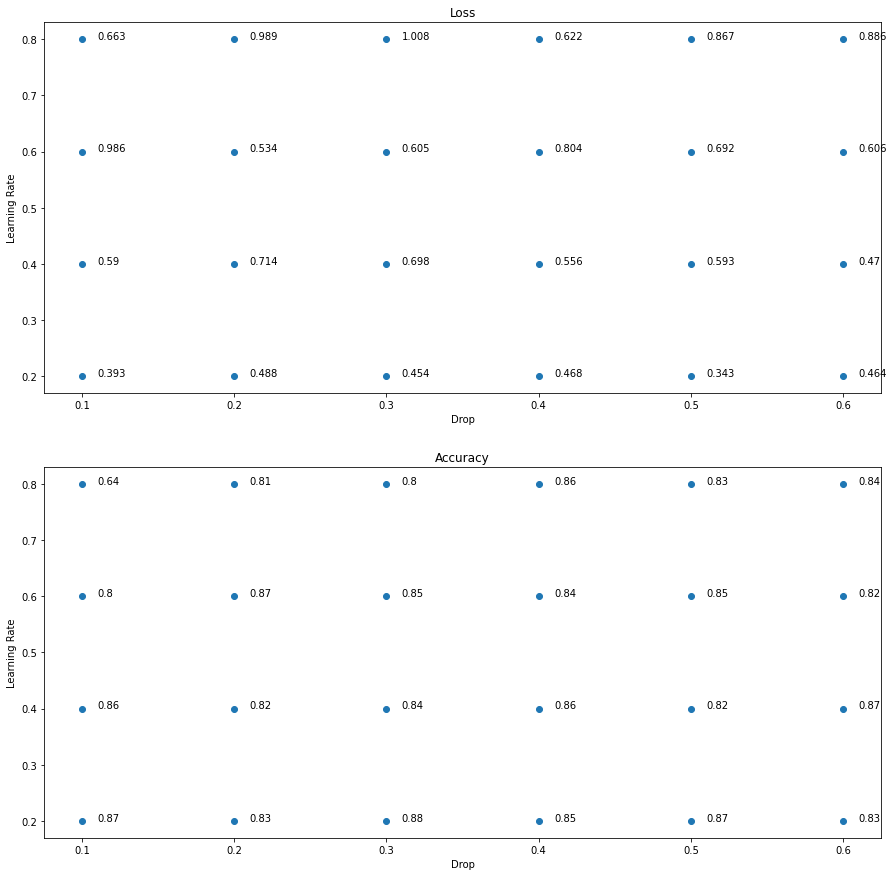

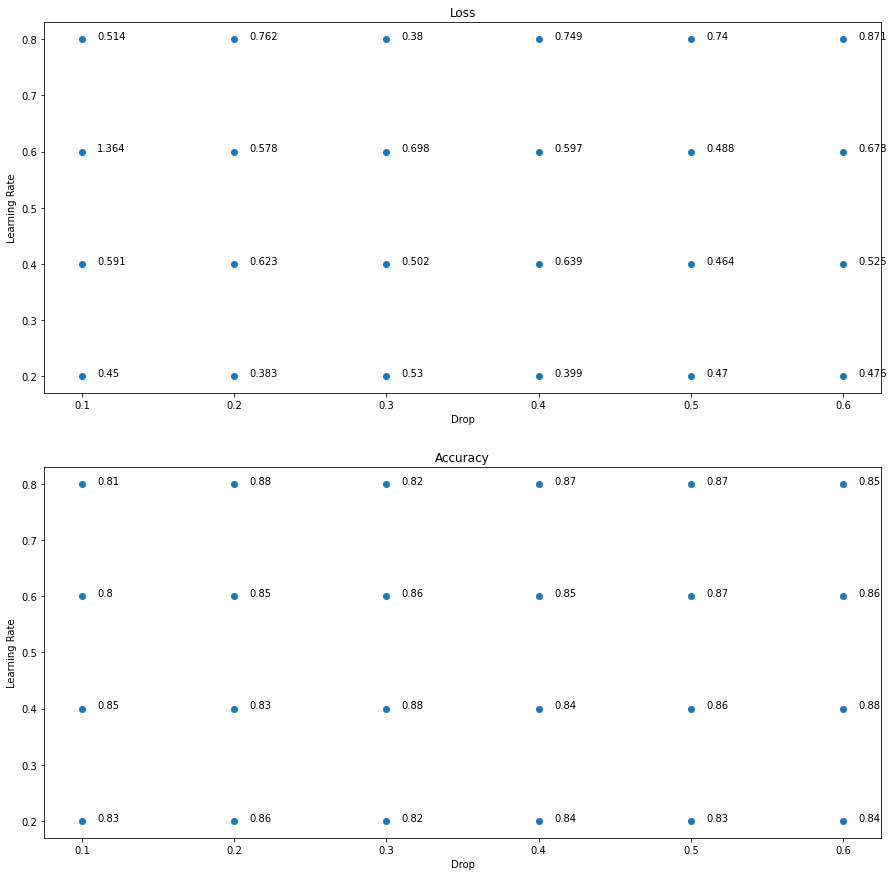

In [71]:
with open('layer_1_res.json', 'r') as f:
    data_cplx = json.load(f)

with open('layer_2_res.json', 'r') as f:
    data_simpl = json.load(f)

plot_results_from_json(data_simpl)
plot_results_from_json(data_cplx)